# 1. [30] If there's no asparagus in Innopolis...

When you find something that you like - whether it is a poem, song, or image, it's often useful to have an option to find similar items, such that you can enjoy songs of the same kind, for example. For this there exist **recommender systems**, and we will build one today. Given a dataset on nutrition of some products, you will be able to search for similar ones, e.g. for replacement in your daily meal: what if you don't have good asparagus in Innopolis?

The recommender system will be based on the vector-space model + dimensionality reduction + cosine similarity measure.

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

## 1.1. Reading the dataset

Next block reads the data from a CSV dataset: https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/nutrition.csv

You can also see this data on GitHub as a beatuful table https://github.com/IUCVLab/information-retrieval/blob/main/datasets/nutrition.csv

In [4]:
# you will need internet connection for this block
csv_url = "https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/nutrition.csv"
dataset = pd.read_csv(csv_url)

# there are no (0) saturated fats in vegetables, that's why we replace N/A values with 0
dataset = dataset.fillna(0)

classes_list = dataset["Food Type"][1:].values
names = dataset["Food and Serving"][1:].values
dimensions = dataset.columns[1:]

print("Names:", *names[:5], "...", sep=" | ")
print()
print("Classes:", *set(classes_list), sep=" | ")
print()
print("Dimensions:", *dimensions[:5], "...", sep=" | ")

dataset.head()

Names: | Asparagus, 5 spears (93 g/3.3 oz) | Bell Pepper, 1 medium (148 g/5.3 oz) | Broccoli, 1 medium stalk (148 g/5.3 oz) | Carrot, 1 carrot, 7" long, 1 1/4" diameter (78 g/2.8 oz) | Cauliflower, 1/6 medium head (99 g/3.5 oz) | ...

Classes: | Seafood, Serving Size (84 g/3 oz) | Vegetables, Serving Size (gram weight/ ounce weight) | Fruits Serving Size (gram weight/ounce weight)

Dimensions: | Calories | Calories from Fat | Total Fat 1 | Total Fat 2 | Sodium 1 | ...


,Food and Serving,Calories,Calories from Fat,Total Fat 1,Total Fat 2,Sodium 1,Sodium 2,Potassium 1,Potassium 2,Total Carbo-hydrate 1,...,Protein,Vitamin A,Vitamin C,Calcium,Iron,Saturated Fat,Saturated Fat 2,Chole-sterol 1,Chole-sterol 2,Food Type
0,0,0.0,0.0,(g),(%DV),(g),(%DV),(g),(%DV),(g),...,(g),(%DV),(%DV),(%DV),(%DV),(%DV),(mg),(%DV),(mg),0
1,"Asparagus, 5 spears (93 g/3.3 oz)",20.0,0.0,0,0,0,0,230,7,4,...,2,10,15,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
2,"Bell Pepper, 1 medium (148 g/5.3 oz)",25.0,0.0,0,0,40,2,220,6,6,...,1,4,190,2,4,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
3,"Broccoli, 1 medium stalk (148 g/5.3 oz)",45.0,0.0,0.5,1,80,3,460,13,8,...,4,6,220,6,6,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
4,"Carrot, 1 carrot, 7"" long, 1 1/4"" diameter (78...",30.0,0.0,0,0,60,3,250,7,7,...,1,110,10,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."


## 1.2. Assigning colors each food item
Building a `color_list` which attributes a color to each item.

In [6]:
classes = list(set(classes_list))
colors = ["red", "green", "blue", "black", "magenta"]
class_colors = {}
for i in range(len(classes)):
    class_colors[classes[i]] = colors[i % len(colors)]
    
print(class_colors)
color_list = [class_colors[a] for a in classes_list]

{'Seafood, Serving Size (84 g/3 oz)': 'red', 'Vegetables, Serving Size (gram weight/ ounce weight)': 'green', 'Fruits Serving Size (gram weight/ounce weight)': 'blue'}


## 1.3. Plotting functions

We will use these functions to visualize data in 2D and 3D.

In [62]:
def show_points_2d(X, Y, xaxis, yaxis):
    global names, classes_list, class_colors
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    classes = set()
    for x, y, name, label in zip(X, Y, names, classes_list):
        if not label in classes:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label], label=label)
            classes.add(label)
        else:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label])
        plt.text(x, y, name)
    plt.legend()
    plt.axvline(0)
    plt.axhline(0)
    plt.show()
# I use labels in the last task
def show_points_3d(X, Y, Z, x_lab="", y_lab="", z_lab=""):
    global color_list
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    for x, y, z, color in zip(X, Y, Z, color_list):
        ax.scatter([x], [y], [z], marker='o', color=color)
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.set_zlabel(z_lab)
    plt.show()
    
def show_matrix(A, xaxis, yaxis):
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.imshow(A)
    plt.show()    

## 1.4. Data Visualization
Matrix `A` will hold numerical data from dataset. It has (61 items)x(22 features) size. In "real" tasks this could be (1B users)x(300 features). In such case each additional feature would cost 8GB of storage. It can be a good idea to cut redundant dimensions.

Raw values, columns are objects (61, 22)
2 random dimensions distribution


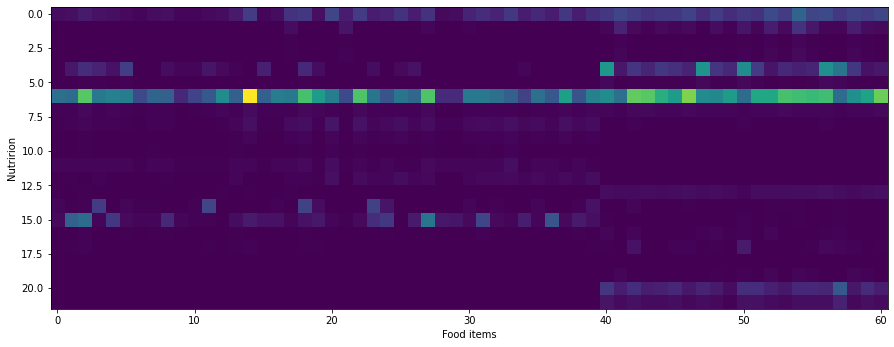

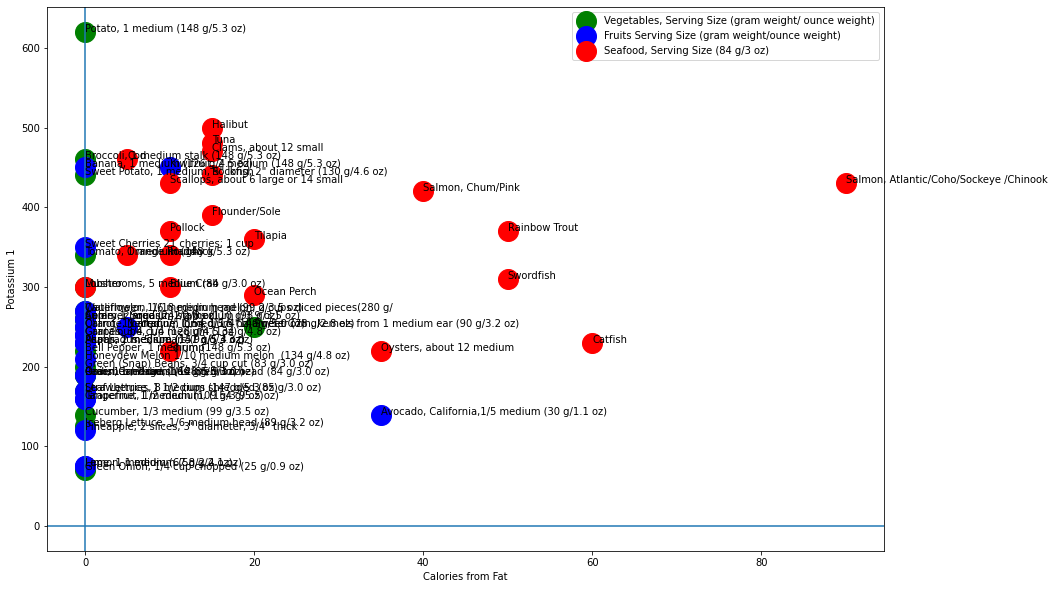

In [52]:
A = np.array(dataset.values[1:,1:-1].astype(float))
print("Raw values, columns are objects", A.shape)
show_matrix(A.T, "Food items", "Nutririon")

print("2 random dimensions distribution")
show_points_2d(A.T[1], A.T[6], dimensions[1], dimensions[6])

## 1.5. [10] Dimensionality reduction with Principal Components Analysis
Principal components are the dimensions, which express dataset diversity in the best way: the variance is maximized along these dimensions. Thus, we can keep only most valuable ones if we are sure they distiguish our data well. Let's keep 3 principal components. **Fill in the code to apply PCA to our data**.

In [9]:
from sklearn.decomposition import PCA
k = 3
pca = PCA(k)
#TODO apply PCA to matrix A, and save the results to Ak
Ak = pca.fit_transform(A)
Ak.shape

(61, 3)

Check how much variance is explained by the first `k` components. Refer to [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [10]:
#TODO print ratios of variance explained by the first k components
print(pca.explained_variance_ratio_)

[0.56816006 0.24450404 0.09653148]


Now, let's **visualize** the data after transformation applied.

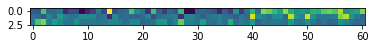

2 first dimensions
3 first dimensions


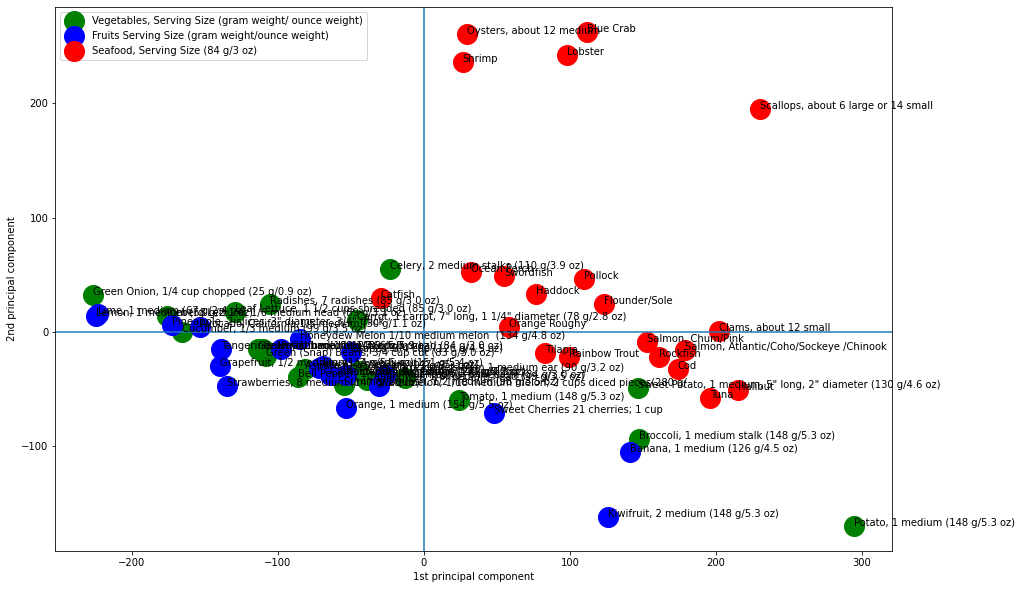

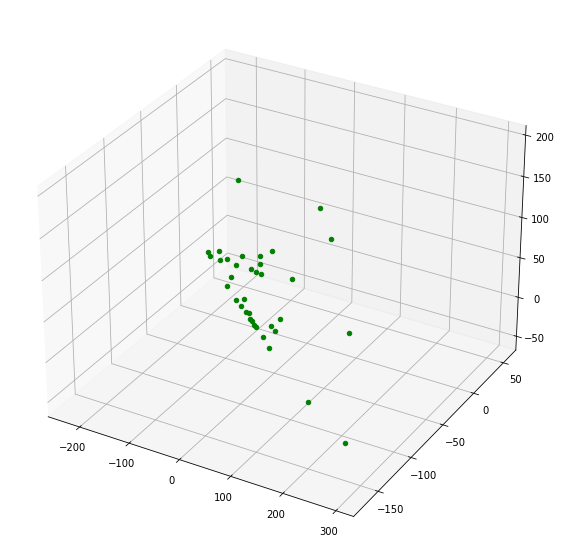

In [63]:
plt.imshow(Ak.T)
plt.show()

print("2 first dimensions")
show_points_2d(Ak.T[0], Ak.T[1], "1st principal component", "2nd principal component")
print("3 first dimensions")
show_points_3d(Ak.T[0], Ak.T[1], Ak.T[2])

## 1.6. [10] Norming
It can happen, that some food is more "watered" than the others. See, how different are celery and popatos in terms of calories. Thus, the norm of each item in dataset can be different, and we cannot easily use $L_2$ distance to estimate the difference. But what we can use - [*cosine similarity*](https://en.wikipedia.org/wiki/Cosine_similarity). Cosine similarity shows, how 2 items are "about the same" even if nutrition is of different scale. Look at the formula of cosine similarity: you will find out that if both vectors are **normed**, then $cos(a, b) = a\cdot b$.

**Thus, your task is to norm the dataset vector-wise (row-wise).**

2 first dimensions


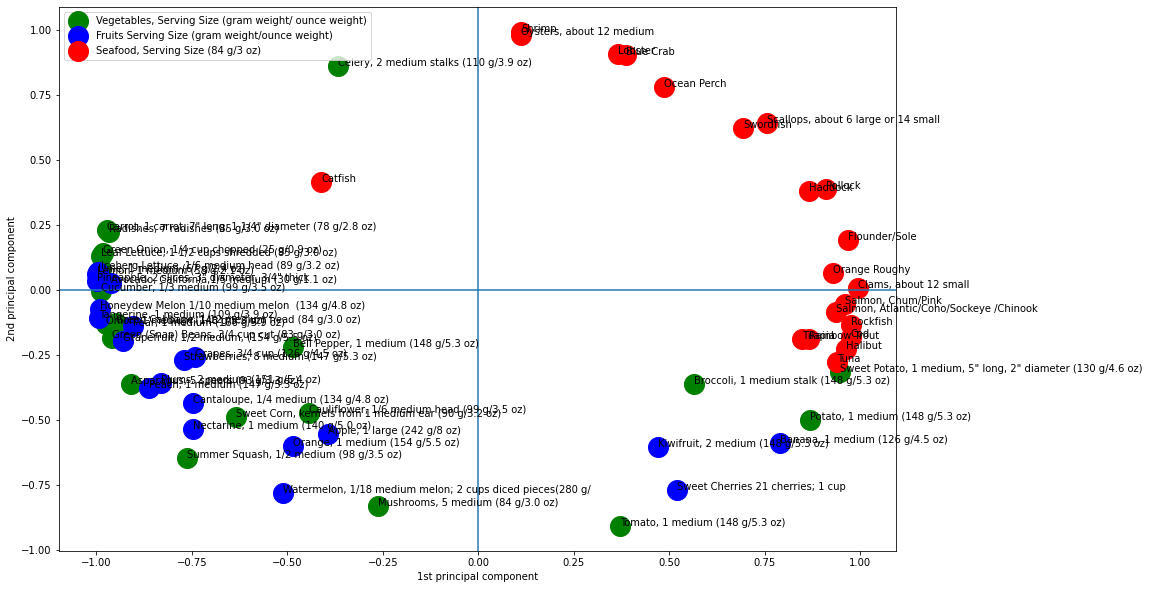

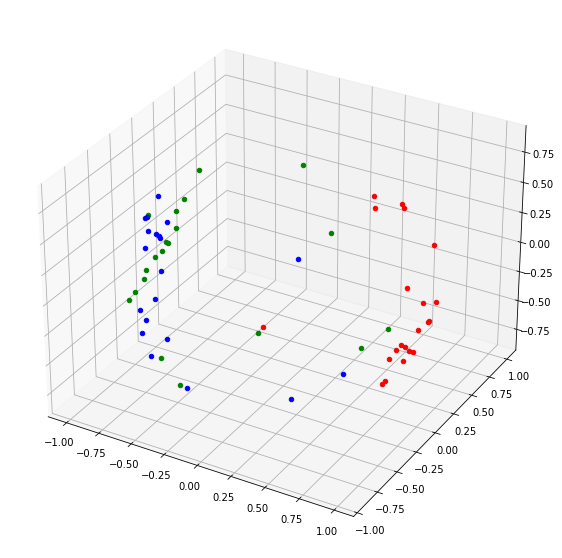

In [12]:
def norm_vectors(A):
    An = A.copy()
    An = np.array([i / np.linalg.norm(i) for i in An])
    # Check if An[i] is normed
    #print([sum(i**2) for i in An])
    return An
    
An = norm_vectors(Ak)

print("2 first dimensions")
show_points_2d(An.T[0], An.T[1], "1st principal component", "2nd principal component")
show_points_3d(An.T[0], An.T[1], An.T[2])

## 1.7. [10] Recommendations
And now the last step left. You represented the data with 3-dimensoinal vectors, instead of 22-dimensional. But we still need the code that will recommend closest food items in terms of nutrition. 

**Please, write the code that will return $k$ closest food items to the provided query vector.**

In [71]:
def find_k_closest(query, dataset, k=5):
    similarity = dataset@query.T
    indexes = np.array(-1*similarity).argsort()[:k]
    # (Row, value , cosine sim)
    return [(i, dataset[i], similarity[i]) for i in indexes]


recommend_to = 0

r = find_k_closest(An[recommend_to,:], An)

print("For:", names[recommend_to])
for k, v, p in r:
    if recommend_to != k: # exclude itself 
        print("\t", names[k], "sim =", p)

[-0.90874354 -0.36058958 -0.2101436 ]
For: Asparagus, 5 spears (93 g/3.3 oz)
	 Peach, 1 medium (147 g/5.3 oz) sim = 0.9900306633803703
	 Green (Snap) Beans, 3/4 cup cut (83 g/3.0 oz) sim = 0.983096080859485
	 Plums, 2 medium (151 g/5.4 oz) sim = 0.9740244451806316
	 Onion, 1 medium (148 g/5.3 oz) sim = 0.9705752498785493


## 1.8. (Extra task) Try this on text data

Now, it's time to check how well does this work for text data. 
1. Load the inverted index you built [at the last lab](2021S-0506%20Index%20and%20Spellchecking.ipynb) with other files needed for the task; 
2. Using these files, build Document-Term Matrix (DTM), where each row is a document, and each column is a term, and at the intersection there's a TF-IDF value;
3. Apply the same procedure as above: **PCA transform + normalization**. Choose the number of dimensions to preserve at least 90\% of variance.
4. Apply similar procedure: **SVD transform + normalization**. Use the same number of dimensions.
5. For a given article (print its url) show urls of 5 closest articles using cosine similarity. Are results different for 3 and 4?
6. Similarly, show urls of closest articles to a short query, such as "last grammy award".

Display cosine similarity for all search results along with urls.

In [21]:
# Place for your code here
import pickle

def build_DTM(index, doc_lengths):
    # Check, if index is ok
    i = 0
    for k, v in index.items():
        print(k, v)
        i+=1
        if i == 5:
            break
    # Count of docs
    D = len(doc_lengths.keys())
    # Count of terms
    T = len(index.keys())
    DTM = np.zeros(shape=(D,T))
    terms = list(index.values())
    print("Terms: ", terms[0:5])
    # For each term
    for j in range(T):
        term = terms[j]
        IDF = math.log(D/(len(term) - 1))
        # term[0], i.e. total count of words is not used
        for i in range(1, len(term)):
            doc_id = term[i][0]
            #TF = term[i][1] / doc_lengths[doc_id]
            TF = math.log(1 + term[i][1])
            DTM[doc_id, j] = TF * IDF
    return DTM

def PCA_transform(DTM, min_var=0.9):
    k = 5
    print("Initial shape of matrix:", DTM.shape)
    DTM_PCA = PCA(k)
    compressed = DTM_PCA.fit_transform(DTM.T)
    vars = DTM_PCA.explained_variance_ratio_
    print("Variances: ", vars[:5], "K: ", k)
    while vars[0] >= min_var:
        k -= 1
        DTM_PCA = PCA(k)
        compressed = DTM_PCA.fit_transform(DTM)
        vars = DTM_PCA.explained_variance_ratio_
        print("Variance: ", vars[0], "K: ", k)
    return norm_vectors(compressed)

def SVD_transform(DTM, dims=5):
    U, sigma, Vh = np.linalg.svd(norm_vectors(DTM), full_matrices=True)
    doc_embeddings = U[:, :dims] @ np.diag(sigma[:dims])
    projection = Vh[:dims, :]
    return doc_embeddings, projection

# My path to the folder with index
TDM_path = "test_collection"
# load index, doc_lengths and doc_urls
with open(os.path.join(TDM_path, 'inverted_index.p'), 'rb') as fp:
    index = pickle.load(fp)
with open(os.path.join(TDM_path, 'doc_lengths.p'), 'rb') as fp:
    doc_lengths = pickle.load(fp)
with open(os.path.join(TDM_path, 'doc_urls.p'), 'rb') as fp:
    doc_urls = pickle.load(fp)

DTM = build_DTM(index, doc_lengths)
DTM_p = PCA_transform(DTM)
embed, proj = SVD_transform(DTM)
# Didn't finished

dominiqu [2, (0, 2)]
min [5, (0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]
readfil [2, (0, 1), (3, 1)]
photo [5, (0, 1), (1, 1), (2, 1), (3, 2)]
french [14, (0, 3), (1, 11)]
Terms:  [[2, (0, 2)], [5, (0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [2, (0, 1), (3, 1)], [5, (0, 1), (1, 1), (2, 1), (3, 2)], [14, (0, 3), (1, 11)]]
(5, 651)
[0.5099428  0.24311014 0.13560289] (651, 3)
3
[[-0.51089221  1.34763657 -0.95282173]
 [-0.33565257  0.33938964  0.24166123]
 [-0.42355482  0.75897769 -0.08777372]
 ...
 [-0.40515807  0.56013228  0.96725749]
 [-0.40515807  0.56013228  0.96725749]
 [-0.40515807  0.56013228  0.96725749]]


# 2. [70] Evolving vector-space model
This lab will be devoted to the use of `doc2vec`/... model for the needs of information retrieval and text classification.  

## 2.1. [40] Searching in the curious facts database
The facts dataset is given [here](https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/facts.txt), take a look.  We want you to retrieve facts **relevant to the query** (whatever it means), for example, you type "good mood", and get to know that Cherophobia is the fear of fun. For this, the idea is to utilize document vectors. However, instead of forming vectors with tf-idf and reducing dimensions, this time we want to obtain fixed-size vectors for documents using `doc2vec` ML model.

### 2.1.1. Loading trained `doc2vec` model

First, let's load the pre-trained `doc2vec` model from https://github.com/jhlau/doc2vec (Associated Press News DBOW (0.6GB)), and install dependency.

Unpack a model into 3 files and target the main one in your code:
```
doc2vec.bin  <---------- this
doc2vec.bin.syn0.npy
doc2vec.bin.sin1neg.npy
```

In [14]:
!pip install gensim

In [15]:
from gensim.models.doc2vec import Doc2Vec
model = Doc2Vec.load('doc2vec.bin', mmap=None)
print(type(model))
print(type(model.infer_vector(["to", "be", "or", "not"])))

<class 'gensim.models.doc2vec.Doc2Vec'>
<class 'numpy.ndarray'>


### 2.1.2. [10] Reading data

Now, let's read the facts dataset. Download it from the abovementioned url and read to the list of sentences.

In [16]:
with open("facts.txt", 'r') as file:
    facts = file.read().split("\n")

### 2.1.3. Tests

In [17]:
print(*facts[:5], sep='\n')

assert len(facts) == 159
assert ('our lovely little planet') in facts[0]

1. If you somehow found a way to extract all of the gold from the bubbling core of our lovely little planet, you would be able to cover all of the land in a layer of gold up to your knees.
2. McDonalds calls frequent buyers of their food "heavy users."
3. The average person spends 6 months of their lifetime waiting on a red light to turn green.
4. The largest recorded snowflake was in Keogh, MT during year 1887, and was 15 inches wide.
5. You burn more calories sleeping than you do watching television.


### 2.1.4. [10] Transforming sentences to vectors

Transform the list of facts to `numpy.array` of vectors corresponding to each document (`sent_vecs`), inferring them from the model we just loaded.

In [18]:
from nltk import word_tokenize
# Delete stop words and punctuation to increase efficiency
class Preprocessor:
    def __init__(self):
        self.stop_words = {'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he', 'in', 'is', 'it', 'its',
                      'of', 'on', 'that', 'the', 'to', 'was', 'were', 'will', 'with'}

    def is_apt_word(self, word):
        # Return only numbers and letters
        if word not in self.stop_words and (word.isalpha() or word.isnumeric()):
            return True
        return False

    def preprocess(self, text):
        preprocessed = word_tokenize(text.lower())
        preprocessed = [i for i in preprocessed if self.is_apt_word(i)]
        return preprocessed

prep = Preprocessor()
# Each fact: string -> list of words without numbers, punctuation etc
# " ".join(i.split(".")[1:] == fact without its number
token_facts = [prep.preprocess(" ".join(i.split(".")[1:])) for i in facts]

print(*token_facts[0:3], sep="\n")
sent_vecs = np.array([model.infer_vector(i) for i in token_facts])

['if', 'you', 'somehow', 'found', 'way', 'extract', 'all', 'gold', 'bubbling', 'core', 'our', 'lovely', 'little', 'planet', 'you', 'would', 'able', 'cover', 'all', 'land', 'layer', 'gold', 'up', 'your', 'knees']
['mcdonalds', 'calls', 'frequent', 'buyers', 'their', 'food', 'heavy', 'users']
['average', 'person', 'spends', '6', 'months', 'their', 'lifetime', 'waiting', 'red', 'light', 'turn', 'green']


### 2.1.5. Tests 

In [19]:
print(sent_vecs.shape)

assert sent_vecs.shape == (159, 300)

(159, 300)


### 2.1.6. [10] Find closest

Now find 5 facts which are closest to the query using cosine similarity measure.

In [20]:
query = "good mood"
prep_query = model.infer_vector(prep.preprocess(query))
r = find_k_closest(norm_vectors([prep_query])[0], norm_vectors(sent_vecs))
print("Results for query:", query)

for k, v, p in r:
    print("\t", facts[k], "sim=", p)

Results for query: good mood
	 68. Cherophobia is the fear of fun. sim= 0.61099946
	 144. Dolphins sleep with one eye open! sim= 0.5767108
	 76. You breathe on average about 8,409,600 times a year sim= 0.57080376
	 100. The tongue is the strongest muscle in the body. sim= 0.5620316
	 141. Months that begin on a Sunday will always have a "Friday the 13th." sim= 0.55402553


### 2.1.7. [10] Measure pFound@5 and mAP@5 for the following query bucket:
```
good mood
gorilla
woman
earth
japan
people
math
```


In [21]:
check_list = ["good mood", "gorilla", "woman", "earth", "japan", "people", "math"]

# Handcrafted relevance, some of them are just containing word in fact
# They are not perfect, I don't know which facts correspond to "good mood" and "math" :(
relevance = {"good mood": [1, 71, 72, 84], "gorilla": [58, 60, 140], "woman": [15, 65, 68],
             "earth": [0, 24, 91, 130, 156], "japan": [63, 67, 126],
             "people":[5, 9, 37, 45, 55, 80, 90, 101, 104, 105, 108, 112],
             "math": [9, 100, 122]}

search = []
# Result of searching for each query
for q in check_list:
    prep_query = model.infer_vector(prep.preprocess(q))
    r = find_k_closest(norm_vectors([prep_query])[0], norm_vectors(sent_vecs))
    # Add the index of found facts
    search.append([i[0] for i in r])
    print("For query ", q, "found:")
    for i in r:
        print(facts[i[0]])
    print("\n")

# From HW1
def mean_avg_precision(search_results, relevance):
    MAP = 0
    # Go through all predictions
    for res_ind in range(len(search_results)):
        precision = 0.0
        # Count of correct answers
        correct_pred = 0
        # Predictions query_id
        true_vals = relevance[check_list[res_ind]]
        answer = search_results[res_ind]
        for pred_ind in range(len(answer)):
            # If prediction with index pred_ind is correct
            if answer[pred_ind] in true_vals:
                correct_pred += 1
                # Count of seen correct / count of total seen
                precision += (correct_pred/(pred_ind + 1))
        print("Precision for", check_list[res_ind], "is ", precision / len(true_vals))
        MAP += precision / len(true_vals)
    return MAP / len(search_results)

# pFound for one query from HW1
def pFound(search_results, relevance):
    pFound = 0
    pBreak = 0.15
    pRel = 0
    pLook = 1
    true_vals = relevance
    for i in search_results:
        # pRel and pLook from the previous iteration
        pLook = pLook * (1 - pBreak) * (1 - pRel)
        if i in true_vals:
            pRel = 0.4
        else:
            pRel = 0
        pFound += pLook * pRel
    return pFound

avg_pFound = 0
for i in range(len(search)):
    avg_pFound += pFound(search[i], relevance[check_list[i]])
avg_pFound /= len(search)

print("\nMAP=", mean_avg_precision(search, relevance))
print("\npFound=", avg_pFound)

For query  good mood found:
68. Cherophobia is the fear of fun.
144. Dolphins sleep with one eye open!
76. You breathe on average about 8,409,600 times a year
136. You can't kill yourself by holding your breath.
18. You cannot snore and dream at the same time.


For query  gorilla found:
137. Human birth control pills work on gorillas.
85. The elephant is the only mammal that can't jump!
57. Gorillas burp when they are happy
106. The male ostrich can roar just like a lion.
55. The word "gorilla" is derived from a Greek word meaning, "A tribe of hairy women."


For query  woman found:
16. Men are 6 times more likely to be struck by lightning than women.
146. In France, it is legal to marry a dead person.
34. 95% of people text things they could never say in person.
121. Birds don't urinate.
97. 111,111,111 X 111,111,111 = 12,345,678,987,654,321


For query  earth found:
88. Earth is the only planet that is not named after a god.
153. For every human on Earth there are 1.6 million ants.


## 2.2. [30] Training doc2vec model and documents classifier

Now you will to train doc2vec model yourself based on [this topic-modeling dataset](https://code.google.com/archive/p/topic-modeling-tool/downloads). It is also cloned in your repository: [just unpack](https://github.com/IUCVLab/information-retrieval/blob/main/datasets/topic-modelling.zip).

### 2.2.1. [10] Read dataset

First, read the dataset - it consists of 4 parts, you need to merge them into single list. 

In [22]:
# Data set is already loaded and located in the path
path = "doc2vec"
files = os.listdir(path)
all_data = []
for file in files:
    with open(os.path.join(path, file), 'r') as fs:
        # The last element from file is also \n
        all_data += fs.read().split('\n')[:-1]

### 2.2.2. Test reading

In [23]:
print(len(all_data))
assert len(all_data) == 15002

15002


## 2.3. Training your own `doc2vec` model

Train a `doc2vec` model based on the dataset you've loaded. The oversimplified example of training is provided.

### 2.3.1. Training example

In [24]:
# small set of tokenized sentences
#from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# just a test set of tokenized sentences
token_text = [word_tokenize(i) for i in all_data]
#print(common_texts, "\n")
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(token_text)]
print(documents[0], "\n")

# train a model
model = Doc2Vec(
    documents,     # collection of texts
    vector_size=5, # output vector size
    window=2,      # maximum distance between the target word and its neighboring word
    min_count=1,   # minimal number of 
    workers=4      # in parallel
)

# clean training data
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# save and load
model.save("d2v.model")
model = Doc2Vec.load("d2v.model")

vec = model.infer_vector(["system", "response"])
print(vec)

TaggedDocument(['therapeutic', 'potential', 'melatonin', 'traumatic', 'central', 'nervous', 'system', 'injury', 'vast', 'literature', 'extolling', 'the', 'benefits', 'melatonin', 'has', 'accumulated', 'during', 'the', 'past', 'four', 'decades', 'melatonin', 'was', 'previously', 'considered', 'importance', 'seasonal', 'reproduction', 'and', 'circadian', 'rhythmicity', 'currently', 'appears', 'versatile', 'anti', 'oxidative', 'and', 'anti', 'nitrosative', 'agent', 'molecule', 'with', 'immunomodulatory', 'actions', 'and', 'profound', 'oncostatic', 'activity', 'and', 'also', 'play', 'role', 'potent', 'neuroprotectant', 'nowadays', 'melatonin', 'sold', 'dietary', 'supplement', 'with', 'differential', 'availability', 'over', 'the', 'counter', 'aid', 'different', 'countries', 'there', 'widespread', 'agreement', 'that', 'melatonin', 'nontoxic', 'and', 'safe', 'considering', 'its', 'frequent', 'long', 'term', 'usage', 'humans', 'both', 'physiological', 'and', 'pharmacological', 'doses', 'with',

### 2.3.2. [10] Form train and test datasets

Transform documents to vectors and split data to train and test sets. Make sure that the split is stratified as the classes are imbalanced.

In [25]:
from sklearn.model_selection import train_test_split
# Sizes of classes. Files were read in this order
y_splits = [10000, 2073, 845, 2084]
y = []
for i in range(len(y_splits)):
    y += [(i + 1) for _ in range(y_splits[i])]
X = [model.infer_vector(i) for i in token_text]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### 2.3.3. [10] Train topics classifier

Train a classifier that would classify any document to one of four categories: fuel, brain injury, music, and economy.
Print a classification report for test data.

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

classifier = AdaBoostClassifier(n_estimators=75,learning_rate=1)
classifier.fit(X_train, y_train)
print("Training is over")

y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

Training is over
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3031
           2       0.45      0.30      0.36       602
           3       0.37      0.19      0.25       257
           4       0.50      0.77      0.61       611

    accuracy                           0.83      4501
   macro avg       0.58      0.56      0.55      4501
weighted avg       0.82      0.83      0.82      4501



Which class is the hardest one to recognize?

Comment: The third, which contain the least amount of samples. I tried to use other hyperparameters,
but it doesn't increase the accuracy significantly.

### 2.4. Bonus task

What if we trained our `doc2vec` model using window size = 5 or 10? Would it improve the classification acccuracy? What about vector dimensionality? Does it mean that increasing it we will achieve better performance in terms of classification?

Explore the influence of these parameters on classification performance, visualizing it as a graph (e.g. window size vs f1-score, vector dim vs f1-score).

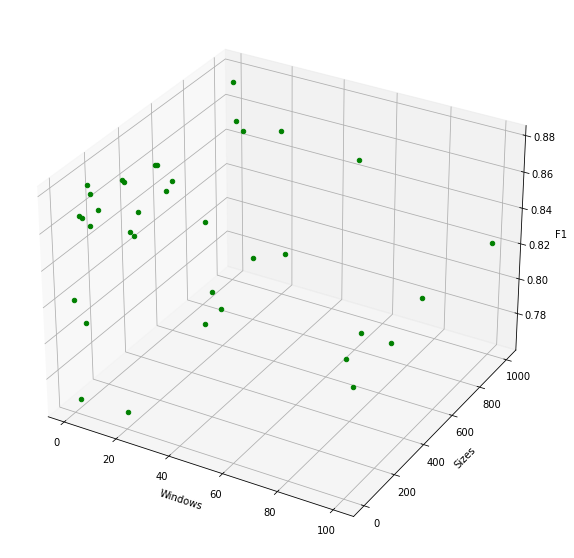

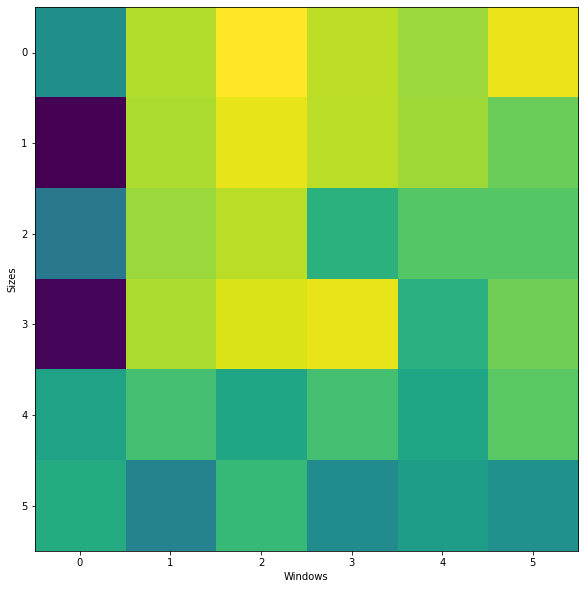

Average F1 score for different window sizes
Average F1 score for different embedding sizes


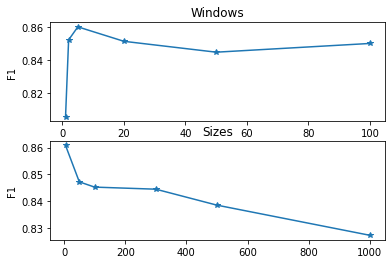

In [70]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

windows = [1, 2, 5, 20, 50, 100]
sizes = [5, 50, 100, 300, 500, 1000]

# You can get this array from get_hyper(), but I already put calculated values
f1_matrix = np.array([[0.8218173739169073, 0.8644745612086203, 0.8773605865363254, 0.8664741168629193, 0.8606976227504999, 0.8740279937791602],
                      [0.7667185069984448, 0.8635858698067096, 0.8731393023772495, 0.8658075983114863, 0.8615863141524106, 0.8524772272828262],
                      [0.8111530770939791, 0.8606976227504999, 0.866029771161964 , 0.8373694734503444, 0.8482559431237503, 0.8480337702732726],
                      [0.7680515441013108, 0.8635858698067096, 0.8711397467229505, 0.8735836480782049, 0.836925127749389 , 0.8535880915352144],
                      [0.8304821150855366, 0.8442568318151521, 0.8315929793379248, 0.8442568318151521, 0.8315929793379248, 0.8489224616751833],
                      [0.8349255720950899, 0.8160408798044879, 0.8409242390579871, 0.8200399911130861, 0.8289269051321928, 0.8227060653188181]])

# Calculate f1-score for different hyperparameters. Takes a long time...
def get_hyper():
    classifier = AdaBoostClassifier(n_estimators=75,learning_rate=1)
    for i in range(len(windows)):
        for j in range(len(sizes)):
            # train a model
            model = Doc2Vec(documents, vector_size=sizes[j], window=windows[i], min_count=1, workers=4)
            # clean training data
            model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

            X = [model.infer_vector(k) for k in token_text]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            f1 = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
            f1_matrix[i][j] = f1
            print(f1)
# Windows
x = [1, 1, 1, 1, 1 ,1, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5,
     20, 20, 20, 20, 20, 20, 50, 50, 50, 50, 50, 50,  100, 100, 100, 100, 100, 100]
# Sizes
y = [5, 50, 100, 300, 500, 1000, 5, 50, 100, 300, 500, 1000, 5, 50, 100, 300, 500, 1000,
     5, 50, 100, 300, 500, 1000, 5, 50, 100, 300, 500, 1000, 5, 50, 100, 300, 500, 1000]


# load some test data for demonstration and plot a wireframe
f1_vec = f1_matrix.flatten()
color_list = ['green' for _ in range(36)]
show_points_3d(x, y, f1_vec, "Windows", "Sizes", "F1")
# rotate the axes and update


# Brighter color - higher value
show_matrix(f1_matrix, "Windows", "Sizes")

win_mean = np.mean(f1_matrix, axis=0)
size_mean = np.mean(f1_matrix, axis=1)


print("Average F1 score for different window sizes\n")
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_ylabel('F1')
ax1.set_title('Windows')

line1, = ax1.plot(windows, win_mean, "*-")

print("Average F1 score for different embedding sizes\n")
ax1 = fig.add_subplot(212)
ax1.set_ylabel('F1')
ax1.set_title('Sizes')

line2, = ax1.plot(sizes, size_mean, "*-")

plt.show()

Comment: The highest f1-score is for window=1, size=100